# Restricted Boltzmann Machine Defintion

In [18]:
# https://github.com/khanhnamle1994/MetaRec/blob/b5e36cb579a88b32cdfb728f35f645d76b24ad95/Boltzmann-Machines-Experiments/RBM-CF-PyTorch/rbm.py#L23
# Import PyTorch library
import torch
import torch.nn as nn


# Create the Restricted Boltzmann Machine architecture
class RBM(nn.Module):
    def __init__(self, n_vis, n_hid):
        """
        Initialize the parameters (weights and biases) we optimize during the training process
        :param n_vis: number of visible units
        :param n_hid: number of hidden units
        """

        # Weights used for the probability of the visible units given the hidden units
        super().__init__()
        self.W = torch.randn(n_hid, n_vis)  # torch.rand: random normal distribution mean = 0, variance = 1

        # Bias probability of the visible units is activated, given the value of the hidden units (p_v_given_h)
        self.v_bias = torch.randn(1, n_vis)  # fake dimension for the batch = 1

        # Bias probability of the hidden units is activated, given the value of the visible units (p_h_given_v)
        self.h_bias = torch.randn(1, n_hid)  # fake dimension for the batch = 1

    def sample_h(self, x):
        """
        Sample the hidden units
        :param x: the dataset
        """

        # Probability h is activated given that the value v is sigmoid(Wx + a)
        # torch.mm make the product of 2 tensors
        # W.t() take the transpose because W is used for the p_v_given_h
        wx = torch.mm(x, self.W.t())
        # print(wx.shape)

        # Expand the mini-batch
        activation = wx + self.h_bias.expand_as(wx)
        # print(activation.shape)

        # Calculate the probability p_h_given_v
        p_h_given_v = torch.sigmoid(activation)

        # print("h sparse", p_h_given_v.is_sparse, torch.bernoulli(p_h_given_v).is_sparse)

        # Construct a Bernoulli RBM to predict whether an user loves the movie or not (0 or 1)
        # This corresponds to whether the n_hid is activated or not activated
        return p_h_given_v, torch.bernoulli(p_h_given_v)

    def sample_v(self, y):
        """
        Sample the visible units
        :param y: the dataset
        """

        # Probability v is activated given that the value h is sigmoid(Wx + a)
        wy = torch.mm(y, self.W)

        # Expand the mini-batch
        activation = wy + self.v_bias.expand_as(wy)

        # Calculate the probability p_v_given_h
        p_v_given_h = torch.sigmoid(activation)

        # print("v sparse", p_v_given_h.is_sparse, torch.bernoulli(p_v_given_h).is_sparse)

        # Construct a Bernoulli RBM to predict whether an user loves the movie or not (0 or 1)
        # This corresponds to whether the n_vis is activated or not activated
        return p_v_given_h, torch.bernoulli(p_v_given_h)

    def train_model(self, v0, vk, ph0, phk):
        """
        Perform contrastive divergence algorithm to optimize the weights that minimize the energy
        This maximizes the log-likelihood of the model
        """

        # Approximate the gradients with the CD algorithm
        self.W += (torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t()

        # Add (difference, 0) for the tensor of 2 dimensions
        self.v_bias += torch.sum((v0 - vk), 0)
        self.h_bias += torch.sum((ph0 - phk), 0)


# General Imports

In [19]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import gzip
import json
from tqdm import tqdm
import os
from collections import Counter
from datetime import datetime
import math

tqdm.pandas()  # for progres_apply etc.


In [20]:
# read file line-by-line and parse json, returns dataframe
def parse_json(filename_gzipped_python_json, read_max=-1):
    # read gzipped content
    f = gzip.open(filename_gzipped_python_json, 'r')

    # parse json
    parse_data = []
    for line in tqdm(f):  # tqdm is for showing progress bar, always good when processing large amounts of data
        line = line.decode('utf-8')
        line = line.replace('true', 'True')  # difference json/python
        line = line.replace('false', 'False')
        parsed_result = eval(line)  # load python nested datastructure
        # print(filename_gzipped_python_json == steam_path + steam_reviews and 'user_id' not in parsed_result)
        # break
        if filename_gzipped_python_json == steam_path + steam_reviews and 'user_id' not in parsed_result:
            continue

        parse_data.append(parsed_result)
        if read_max != -1 and len(parse_data) > read_max:
            print(f'Break reading after {read_max} records')
            break
    print(f"Reading {len(parse_data)} rows.")

    # create dataframe
    df = pd.DataFrame.from_dict(parse_data)
    return df


In [21]:
steam_path = './data/'
metadata_games = 'steam_games.json.gz'
user_items = 'australian_users_items.json.gz'
user_reviews = 'australian_user_reviews.json.gz'
game_bundles = 'bundle_data.json.gz'
steam_reviews = 'steam_reviews.json.gz'

# Reading Australien Dataset

In [22]:

# for dataset in [metadata_games, user_items, user_reviews, game_bundles, steam_reviews]:
for dataset in [user_reviews]:
    print(f"----- {dataset}-----")
    size = os.path.getsize(steam_path + dataset)
    print(f'Size of file is {size / 1000000}MB')
    df_metadata = parse_json(steam_path + dataset)
    pd.set_option('display.max_colwidth', None)

#   display(df_metadata.describe(include='all'))

25799it [00:03, 6816.97it/s]


----- australian_user_reviews.json.gz-----
Size of file is 6.940139MB
Reading 25799 rows.


In [23]:
user_reviews_df = parse_json(steam_path + user_reviews)
user_reviews_df = user_reviews_df.drop_duplicates(subset='user_id')
user_item_df = parse_json(steam_path + user_items)
user_item_df = user_item_df.drop_duplicates(subset='user_id')

25799it [00:03, 6969.90it/s]
88310it [01:42, 863.89it/s] 


Reading 25799 rows.
Reading 88310 rows.


In [24]:
user_reviews_df_exploded = user_reviews_df.explode('reviews')
user_reviews_df_exploded = user_reviews_df_exploded.dropna()
user_item_df_exploded = user_item_df.explode('items')
user_item_df_exploded = user_item_df_exploded.dropna()


In [25]:
def func(x):
    return x['recommend'], x["item_id"]


def func2(x):
    return x["item_id"], x['playtime_forever']


user_reviews_df_exploded['recommended'], user_reviews_df_exploded["item_id"] = zip(
    *user_reviews_df_exploded['reviews'].map(func)
)
user_item_df_exploded['item_id'], user_item_df_exploded['playtime'] = zip(
    *user_item_df_exploded['items'].map(func2)
)

In [26]:
user_reviews_df_exploded.reset_index()
user_reviews_df_exploded = user_reviews_df_exploded[['user_id', 'item_id', 'recommended']]

user_item_df_exploded.reset_index()
user_item_df_exploded = user_item_df_exploded[['user_id', 'item_id', 'playtime']]

In [27]:
enkeltrue = user_reviews_df[['reviews']].apply(lambda x: [elem['recommend'] for elem in x['reviews']], axis=1)
enkeltrue.loc[enkeltrue.map(set).map(len) > 1]

24                         [False, True]
26       [True, True, True, False, True]
36                         [True, False]
60             [False, True, True, True]
71                         [False, True]
                      ...               
25758    [True, True, True, False, True]
25761                      [False, True]
25764                [True, True, False]
25768    [True, True, False, True, True]
25785                [True, True, False]
Length: 3684, dtype: object

In [28]:
dct = {}


def map_to_consecutive_id(uuid):
    if uuid in dct:
        return dct[uuid]
    else:
        id = len(dct)
        dct[uuid] = id
        return id


user_reviews_df_exploded['item_id_int'] = user_reviews_df_exploded['item_id'].progress_apply(map_to_consecutive_id)
user_reviews_df_exploded.dtypes
user_item_df_exploded['item_id_int'] = user_item_df_exploded['item_id'].progress_apply(map_to_consecutive_id)
f = open("item_dct.json", 'w')
json.dump(dct, f)
f.close()

100%|██████████| 5094082/5094082 [00:10<00:00, 463858.08it/s]


In [29]:
dct = {}
user_reviews_df_exploded['user_id_int'] = user_reviews_df_exploded['user_id'].progress_apply(map_to_consecutive_id)
user_item_df_exploded['user_id_int'] = user_item_df_exploded['user_id'].progress_apply(map_to_consecutive_id)

from sklearn.model_selection import train_test_split

# train_df, test_df = train_test_split(user_reviews_df_exploded, test_size=0.2)
train_df, test_df = train_test_split(user_item_df_exploded, test_size=0.2)

test_df_grouped = test_df.groupby('user_id_int').agg(list)
test_df_grouped = test_df_grouped.reset_index()

train_df_grouped = train_df.groupby('user_id_int').agg(list)
train_df_grouped = train_df_grouped.reset_index()


100%|██████████| 5094082/5094082 [00:10<00:00, 485859.63it/s]


In [30]:
# Create scipy csr matrix
def get_sparse_matrix(df):
    shape = (user_reviews_df_exploded['user_id_int'].max() + 1, user_reviews_df_exploded['item_id_int'].max() + 1)

    user_ids = []
    item_ids = []
    values = []
    for idx, row in df.iterrows():
        items = row['item_id_int']
        user = row['user_id_int']

        recommended = row['recommended']
        user_ids.extend([user] * len(items))
        item_ids.extend(items)
        values.extend([2 if recommended[i] else 1 for i in range(len(items))])
    # create csr matrix
    # values = np.ones(len(user_ids))
    matrix = scipy.sparse.csr_matrix((values, (user_ids, item_ids)), shape=shape, dtype=np.int32)
    return matrix


def get_sparse_matrix2(df):
    shape = (user_item_df_exploded['user_id_int'].max() + 1, user_item_df_exploded['item_id_int'].max() + 1)

    user_ids = []
    item_ids = []
    values = []
    for idx, row in df.iterrows():
        items = row['item_id_int']
        user = row['user_id_int']

        recommended = row['playtime']
        user_ids.extend([user] * len(items))
        item_ids.extend(items)
        values.extend([2 if recommended[i] else 1 for i in range(len(items))])
    # create csr matrix
    # values = np.ones(len(user_ids))
    matrix = scipy.sparse.csr_matrix((values, (user_ids, item_ids)), shape=shape, dtype=np.int32)
    return matrix


In [31]:
test_matrix = get_sparse_matrix2(test_df_grouped)

train_matrix = get_sparse_matrix2(train_df_grouped)
train_matrix


<73757x11339 sparse matrix of type '<class 'numpy.intc'>'
	with 4075265 stored elements in Compressed Sparse Row format>

-------
start training
calculating test scores
finished epoch 0
calculating test scores
finished epoch 1


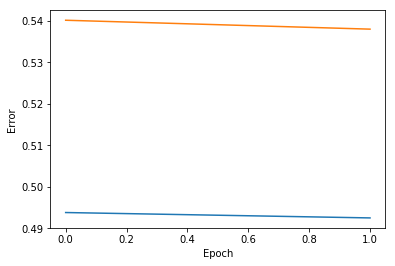

In [32]:
def score_model(rbm):
    test_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
    s = 0  # a counter (float type)
    # for loop - go through every single user
    for id_user in range(user_reviews_df_exploded['user_id_int'].max() + 1):
        v = train_matrix[id_user:id_user + 1]  # training set inputs are used to activate neurons of my RBM
        vt = test_matrix[id_user:id_user + 1]  # target
        # v = convert_sparse_matrix_to_sparse_tensor(training_sample)
        # vt = convert_sparse_matrix_to_sparse_tensor(training_sample2)
        v = v.todense()
        vt = vt.todense()

        # v = v.to_dense()
        # vt = vt.to_dense()
        v = v - 1
        vt = vt - 1
        v = torch.Tensor(v)
        vt = torch.Tensor(vt)
        if len(vt[vt > -1]) > 0:
            _, h = rbm.sample_h(v)
            _, v = rbm.sample_v(h)

            # Update test RMSE reconstruction error
            test_recon_error += torch.sqrt(torch.mean((vt[vt > -1] - v[vt > -1]) ** 2))
            s += 1

    return test_recon_error / s


print('-------')
n_vis = user_item_df_exploded['item_id_int'].max() + 1
n_hidden = 12
batch_size = 128
train_errors = []
test_errors = []
rbm = RBM(n_vis, n_hidden)


# https://stackoverflow.com/questions/40896157/scipy-sparse-csr-matrix-to-tensorflow-sparsetensor-mini-batch-gradient-descent
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()

    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    # print(values)
    # print("values", v)
    shape = coo.shape

    return torch.sparse.FloatTensor(i, v, torch.Size(shape))


print("start training")
for epoch in range(2):
    rbm.train()
    train_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
    s = 0

    for user_id in range(0, user_item_df_exploded['user_id_int'].max() + 1 - batch_size, batch_size):
        training_sample = train_matrix[user_id: user_id + batch_size]
        training_sample2 = train_matrix[user_id: user_id + batch_size]
        # print(training_sample)
        v0 = convert_sparse_matrix_to_sparse_tensor(training_sample)
        # print(v0.coalesce().indices())
        vk = convert_sparse_matrix_to_sparse_tensor(training_sample2)

        v0 = v0.to_dense()
        vk = vk.to_dense()
        v0 = v0.sub(1)
        vk = vk.sub(1)

        ph0, _ = rbm.sample_h(v0)

        # Third for loop - perform contrastive divergence
        for k in range(10):
            _, hk = rbm.sample_h(vk)
            _, vk = rbm.sample_v(hk)

            # We don't want to learn when there is no rating by the user, and there is no update when rating = -1
            # Remove indices from vk vector that are not in the v0 vector => get sparse tensor again
            vk[v0 < 0] = v0[v0 < 0]
            vksparse = vk.to_sparse()
            # print("v0", v0)
            # print("v0", v0.add(1).to_sparse())
            # print("vk", vk.add(1).to_sparse())

            # print(k)

        phk, _ = rbm.sample_h(vk)

        rbm.train_model(v0, vk, ph0, phk)

        train_recon_error += torch.sqrt(torch.mean((v0[v0 > 0] - vk[v0 > 0]) ** 2))
        s += 1

        # print((torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t().shape)
        # print(torch.sum((-vk + v0), 0).shape)
        # print(torch.sum((ph0 - phk), 0).shape)

    train_errors.append(train_recon_error / s)

    print('calculating test scores')
    rbm.eval()
    test_errors.append(score_model(rbm))

    print('finished epoch', epoch)

import matplotlib.pyplot as plt

# Plot the RMSE reconstruction error with respect to increasing number of epochs
plt.plot(train_errors, label="train")
plt.plot(test_errors, label="test")
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.savefig('errors.jpg')

# Evaluate the RBM on test set
# test_recon_error = score_model(rbm)
# print("Final error", test_recon_error)


In [33]:
torch.save(rbm.state_dict(), "./network")

In [34]:
rbm = RBM(n_vis, n_hidden)
rbm.load_state_dict(torch.load("./network"))
rbm.eval()


RBM()